# Pandas Introduction Part 3

## Overview

This notebook uses the IMDB dataset from Kaggle:  
https://www.kaggle.com/PromptCloudHQ/imdb-data#IMDB-Movie-Data.csv

GroupBy examples are presented.

In [1]:
import pandas as pd
import numpy as np

## Read Movie Data Set
This data was read in and preprocessed in Pandas02.  Load the pickled dataframe.

In [2]:
import pickle
with open('../data/movies.pickle','rb') as p:
    movies = pickle.load(p)

In [3]:
# display first 2 rows of the DataFrame
movies.head(2)

,ID,Genre,Description,Director,Actors,Year,Runtime,Rating,Votes,Revenue,Metascore
Title,,,,,,,,,,,
Guardians of the Galaxy,1,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0


## GroupBy

The DataFrame.groupby(varibles) method will split a dataframe into an iterator of (key,value) pairs where:
* key: is each unique combination of values of the specified variables
* value: is a dataframe of rows which have the key values

This is commonly referred to as:
* split: the dataframe by each unique value of the variables into a collection of dataframes
* apply: an aggregation to each split dataframe
* combine: the result back into a Series or DataFrame

In [4]:
# examine the key,value pairs created by groupby
grouped = movies.groupby('Year')

# for each df: display Director, Year, Rating; first 3 rows
for key,df in grouped:
    print(key)
    display(df[['Director','Year', 'Rating']].head(3))

2006


,Director,Year,Rating
Title,,,
The Prestige,Christopher Nolan,2006,8.5
Pirates of the Caribbean: Dead Man's Chest,Gore Verbinski,2006,7.3
The Departed,Martin Scorsese,2006,8.5


2007


,Director,Year,Rating
Title,,,
5- 25- 77,Patrick Read Johnson,2007,7.1
Pirates of the Caribbean: At World's End,Gore Verbinski,2007,7.1
No Country for Old Men,Ethan Coen,2007,8.1


2008


,Director,Year,Rating
Title,,,
The Dark Knight,Christopher Nolan,2008,9.0
Mamma Mia!,Phyllida Lloyd,2008,6.4
Twilight,Catherine Hardwicke,2008,5.2


2009


,Director,Year,Rating
Title,,,
Inglourious Basterds,Quentin Tarantino,2009,8.3
Avatar,James Cameron,2009,7.8
Star Trek,J.J. Abrams,2009,8.0


2010


,Director,Year,Rating
Title,,,
Inception,Christopher Nolan,2010,8.8
Shutter Island,Martin Scorsese,2010,8.1
Diary of a Wimpy Kid,Thor Freudenthal,2010,6.2


2011


,Director,Year,Rating
Title,,,
Pirates of the Caribbean: On Stranger Tides,Rob Marshall,2011,6.7
The Help,Tate Taylor,2011,8.1
Thor,Kenneth Branagh,2011,7.0


2012


,Director,Year,Rating
Title,,,
Prometheus,Ridley Scott,2012,7.0
The Avengers,Joss Whedon,2012,8.1
The Dark Knight Rises,Christopher Nolan,2012,8.5


2013


,Director,Year,Rating
Title,,,
The Wolf of Wall Street,Martin Scorsese,2013,8.2
Prisoners,Denis Villeneuve,2013,8.1
12 Years a Slave,Steve McQueen,2013,8.1


2014


,Director,Year,Rating
Title,,,
Guardians of the Galaxy,James Gunn,2014,8.1
Interstellar,Christopher Nolan,2014,8.6
John Wick,Chad Stahelski,2014,7.2


2015


,Director,Year,Rating
Title,,,
Bahubali: The Beginning,S.S. Rajamouli,2015,8.3
Star Wars: Episode VII - The Force Awakens,J.J. Abrams,2015,8.1
Fifty Shades of Grey,Sam Taylor-Johnson,2015,4.1


2016


,Director,Year,Rating
Title,,,
Split,M. Night Shyamalan,2016,7.3
Sing,Christophe Lourdelet,2016,7.2
Suicide Squad,David Ayer,2016,6.2


In [5]:
# compute the aggregate and combine the results, by hand
grouped = movies.groupby('Year')

# data is a list of dictionaries
data = []
for key,df in grouped:
    data.append({'Year':key, 'Count':len(df.index)})
    
df = pd.DataFrame(data=data).set_index('Year')
df

,Count
Year,
2006,44
2007,53
2008,52
2009,51
2010,60
2011,63
2012,64
2013,91
2014,98


### Have Pandas Perform Split-Apply-Combine in a Single Line

In the example below:  
assign is like: **movies\['Count'\] = movies\['ID'\]**  
1. **split:** groupby('Year')
2. **aggregate:** using a dictionary which maps the column to the agg function: **df\['Count'\].size()**
3. **combine:** is performed automatically, using the column name(s) that the aggregate function(s) were applied to

The index of the returned dataframe is the variable(s) used in the groupby.

In [6]:
df = movies.assign(
    Count=movies['ID'],
).groupby('Year').agg(dict(Count='size'))
df

,Count
Year,
2006,44
2007,53
2008,52
2009,51
2010,60
2011,63
2012,64
2013,91
2014,98


In [7]:
# number of rows == number of unique years
len(df) == movies['Year'].nunique()

True

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid') # enable seaborn style

In [9]:
df = df.reset_index()

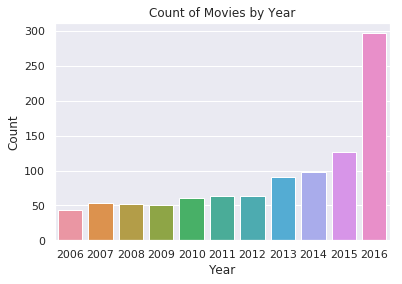

In [10]:
sns.barplot(x='Year', y='Count', data=df).set_title('Count of Movies by Year');

### Naming the Columns created by the aggregates
This requires a bit of tricky syntax.

In [11]:
df = movies.assign(
    Count=movies['Rating'],
    Rating=movies['Rating'],
).groupby('Director').agg(dict(Count='size', Rating='mean'))
df.head(3)

,Count,Rating
Director,,
Aamir Khan,1,8.5
Abdellatif Kechiche,1,7.8
Adam Leon,1,6.5


In [12]:
# find the highest rated directors who directed at least 3 movies
highest_rated = df[df['Count'] >= 3].nlargest(n=5,columns='Rating')
highest_rated

,Count,Rating
Director,,
Christopher Nolan,5,8.68
Martin Scorsese,5,7.92
Quentin Tarantino,4,7.90
Wes Anderson,3,7.90
David Fincher,5,7.82


In [13]:
grouped = movies.groupby('Director')

dfs = []
for director in highest_rated.index:
    dfs.append(pd.DataFrame(data=grouped.get_group(director)['Rating'].values, columns=[director]))

In [14]:
grouped = movies.groupby('Director')

dfs = []
for director in highest_rated.index:
    dfs.append(pd.Series(data=grouped.get_group(director)['Rating'].values, name=director))

In [15]:
# create data in "long form" for plotting
grouped = movies.groupby('Director')

data = []
for director in highest_rated.index:
    for rating in grouped.get_group(director)['Rating'].values:
        data.append((director, rating))
data

df_dir_rating = pd.DataFrame(data=data, columns=['Director', 'Rating'])
df_dir_rating

,Director,Rating
0,Christopher Nolan,8.6
1,Christopher Nolan,9.0
2,Christopher Nolan,8.5
3,Christopher Nolan,8.8
4,Christopher Nolan,8.5
5,Martin Scorsese,7.3
6,Martin Scorsese,8.2
7,Martin Scorsese,8.5
8,Martin Scorsese,8.1
9,Martin Scorsese,7.5


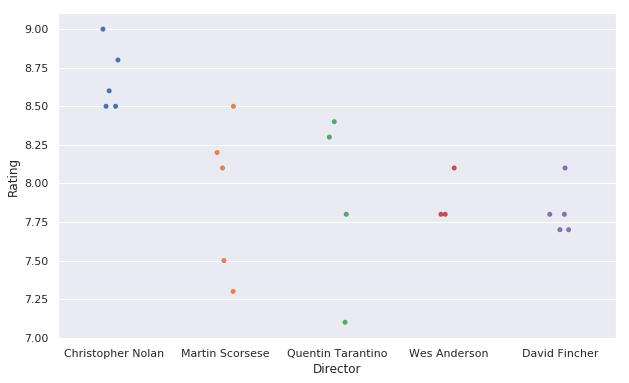

In [16]:
plt.figure(figsize=(10,6))
sns.stripplot(x='Director', y='Rating', data=df_dir_rating, jitter=0.1);